# Import Libraries

In [2]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
    !pip install torchvision
    !pip install torch==1.4.0
    !pip install torchaudio==0.4.0
    %matplotlib inline
    !python pytorch-xla-env-setup.py --version $VERSION

In [ ]:
!pip uninstall -y torch
!pip install torch==1.8.2+cpu -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install -q cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl


In [9]:
pip install torchviz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=0fc8fa5145100dddc423dd7a510e858b8fb7b81af92a3c928aacac8bbe186688
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


In [ ]:
import torch

import torch_xla
import torch_xla.core.xla_model as xm

In [10]:
import os
import gc
import cv2
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from skimage.io import MultiImage
from joblib import Parallel, delayed

from sklearn.utils import shuffle
from colorama import Fore, Back, Style
from keras.utils import to_categorical as cat

import torch
import torch.nn as nn
from torch.optim import Adam
from torch import LongTensor as LongTensor
from torch import FloatTensor as FloatTensor



from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet18, densenet121, mobilenet_v2
from albumentations import RandomRotate90, Flip, Compose, Normalize, RandomResizedCrop

In [11]:
np.random.seed(42)
torch.manual_seed(42)

# Hyperparameters

In [12]:
FOLDS = 8
EPOCHS = 4

RRC = 1.0
FLIP = 1.0
NORM = 1.0
ROTATE = 1.0
LR = (1e-4, 1e-3)
MODEL_SAVE_PATH = "resnet_model"

WIDTH = 512
HEIGHT = 512
BATCH_SIZE = 128
VAL_BATCH_SIZE = 128

# Data Path

In [13]:
DATA_PATH = '/content/drive/MyDrive/PANDA/'
RESIZED_PATH = '/content/drive/MyDrive/PANDA/train_images/'

In [14]:
TEST_DATA_PATH = DATA_PATH + 'test.csv'
TRAIN_DATA_PATH = DATA_PATH + 'train.csv'
TEST_IMG_PATH = DATA_PATH + 'test_images/'
TRAIN_IMG_PATH = RESIZED_PATH + 'train_images/'
SAMPLE_SUB_PATH = DATA_PATH + 'sample_submission.csv'

In [15]:
test_df = pd.read_csv(TEST_DATA_PATH)
train_df = pd.read_csv(TRAIN_DATA_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

# Convert Gleason scores to list format

In [16]:
gleason_replace_dict = {0:0, 1:1, 3:2, 4:3, 5:4}

In [17]:
def process_gleason(gleason):
    if gleason == 'negative': gs = (1, 1)
    else: gs = tuple(gleason.split('+'))
    return [gleason_replace_dict[int(g)] for g in gs]

In [18]:
train_df.gleason_score = train_df.gleason_score.apply(process_gleason)

In [19]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,"[0, 0]"
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,"[0, 0]"
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,"[3, 3]"
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,"[3, 3]"
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,"[0, 0]"


# Display few images 

In [20]:
def display_images(num):
    sq_num = np.sqrt(num)
    assert sq_num == int(sq_num)

    sq_num = int(sq_num)
    fig, ax = plt.subplots(nrows=sq_num, ncols=sq_num, figsize=(20, 20))

    for i in range(int(sq_num)):
        for j in range(int(sq_num)):
            idx = i*sq_num + j
            path = TRAIN_IMG_PATH + train_df.image_id[idx]
    
            path += '.png'
            ax[i, j].imshow(cv2.imread(path))
            ax[i, j].set_title('Image {}'.format(idx), fontsize=12)

    plt.show()

# Build Pytorch Dataset

In [26]:
class PANDADataset(Dataset):
    def __init__(self, data, img_path, is_val=False, is_train=False):

        self.data = data
        self.is_val = is_val
        self.is_train = is_train
        self.image_path = img_path
        self.image_id = data.image_id
        self.aug = self.norm = Normalize(p=NORM)

        if is_train or is_val:
            self.isup_grade = data.isup_grade
            self.gleason_score = data.gleason_score

            if is_train:
                self.flip = Flip(p=FLIP)
                self.rotate = RandomRotate90(p=ROTATE)
                self.crop = RandomResizedCrop(p=RRC, width=WIDTH, height=HEIGHT)
                self.aug = Compose([self.flip, self.rotate, self.crop, self.norm], p=1)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        path = self.image_path + self.image_id[idx]

        if self.is_train or self.is_val:
            path += '.png'
            image = cv2.imread(path)
        else:
            path += '.tiff'
            image = MultiImage(path)[-1]
            image = cv2.resize(image, (HEIGHT, WIDTH))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.aug(image=image)['image'].reshape((3, HEIGHT, WIDTH))
        
        if self.is_train or self.is_val:
            isup_grade = cat([self.data.isup_grade[idx]], num_classes=6)
            gleason_0 = cat([self.data.gleason_score[idx][0]], num_classes=5)
            gleason_1 = cat([self.data.gleason_score[idx][1]], num_classes=5)
            target = np.concatenate([isup_grade, gleason_0, gleason_1], axis=1)
            
        if self.is_train or self.is_val:
            return FloatTensor(image), FloatTensor(target)
        else:
            return FloatTensor(image)

# Build ResNet Model

In [27]:
class ResNetDetector(nn.Module):
    def __init__(self):
        super(ResNetDetector, self).__init__()

        self.softmax = nn.Softmax(dim=1)
        self.dense_1 = nn.Linear(512, 6)
        self.dense_2 = nn.Linear(512, 5)
        self.dense_3 = nn.Linear(512, 5)
        self.resnet = resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
    def forward(self, img):
        feat = self.resnet(img).squeeze()

        isup_logit = self.dense_1(feat)
        gleason_logit_0 = self.dense_2(feat)
        gleason_logit_1 = self.dense_3(feat)
        
        isup_prob = self.softmax(isup_logit)
        gleason_prob_0 = self.softmax(gleason_logit_0)
        gleason_prob_1 = self.softmax(gleason_logit_1)
        return torch.cat([isup_prob, gleason_prob_0, gleason_prob_1], axis=1)

# RESNET ARCHITECTURE

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

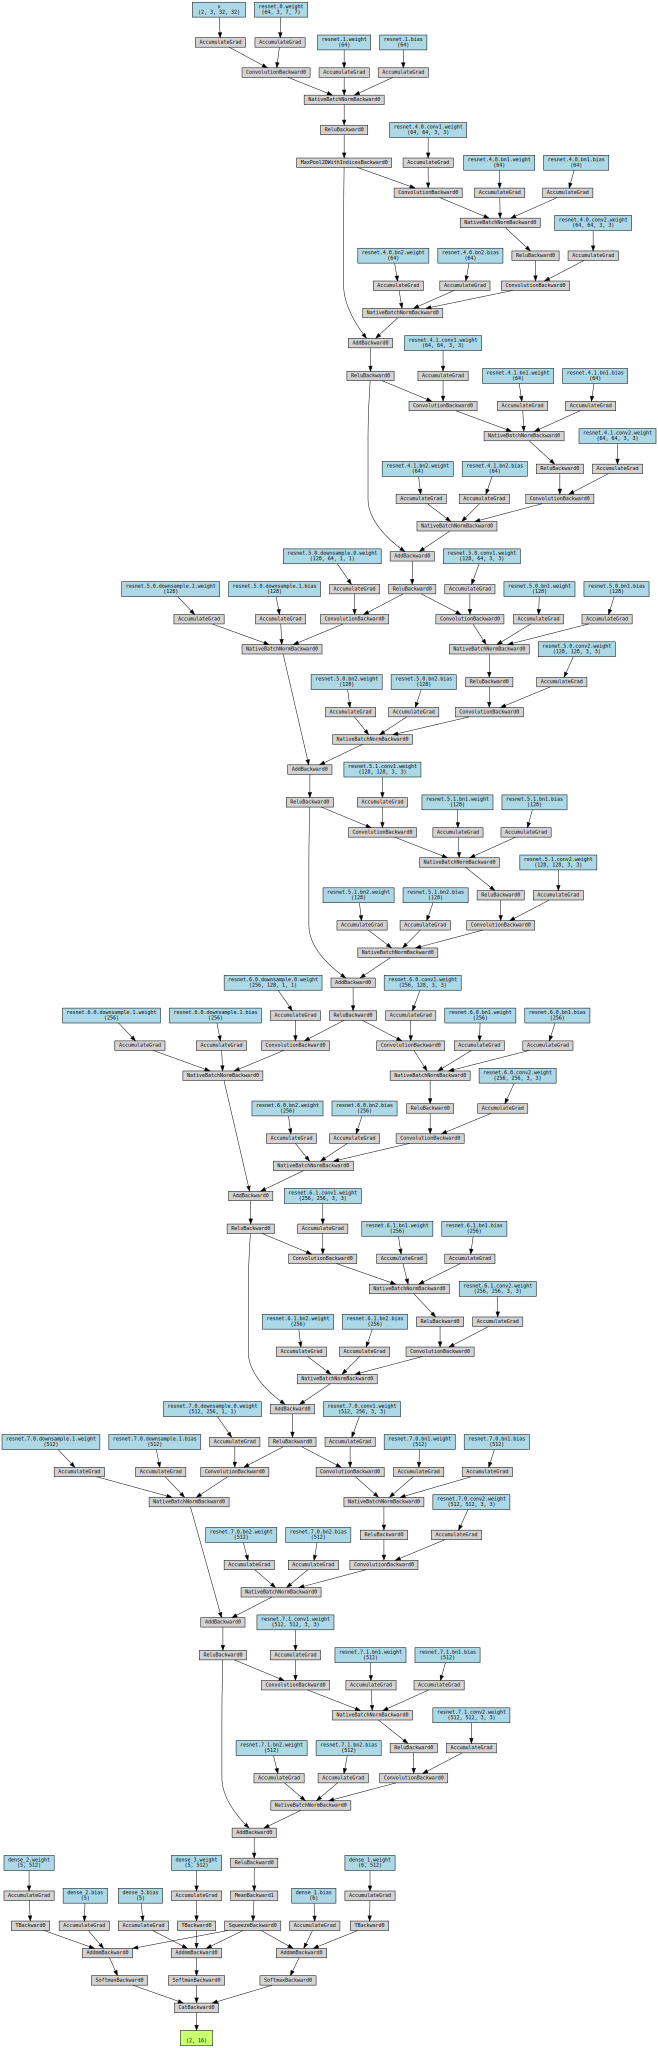

In [28]:
model = ResNetDetector()
x = torch.randn(2, 3, 32, 32).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))

# Split train.csv into 8 folds

In [29]:
val_sets, train_sets = [], []
val_splits = np.int32((np.arange(FOLDS + 1)/FOLDS) * len(train_df))
val_indices = [[val_splits[i], val_splits[i+1]] for i in range(FOLDS)]

for fold in tqdm(range(FOLDS)):
    val_idx = val_indices[fold]
    if fold == FOLDS - 1: val_idx[1] -= 1
    val_sets.append(train_df[val_idx[0]:val_idx[1]])
    train_sets.append(pd.concat([train_df[:val_idx[0]], train_df[val_idx[1]:]]))

  0%|          | 0/8 [00:00<?, ?it/s]

# Define Cross Entropy and Accuracy

In [30]:
def cel(inp, targ):
    _, labels = targ.max(dim=1)
    return nn.CrossEntropyLoss()(inp, labels)

def acc(inp, targ):
    inp_idx = inp.max(axis=1).indices
    targ_idx = targ.max(axis=1).indices
    return (inp_idx == targ_idx).float().sum(axis=0)/len(inp_idx)

# Define Custom PANDA Loss for Multitask Model

In [31]:
def panda_cel(inp, targ):
    isup_loss = cel(inp[:, :6], targ[:, :6])
    gleason_loss_0 = cel(inp[:, 6:11], targ[:, 6:11])
    gleason_loss_1 = cel(inp[:, 11:16], targ[:, 11:16])
    return [isup_loss, gleason_loss_0, gleason_loss_1],\
           isup_loss + gleason_loss_0 + gleason_loss_1

def panda_acc(inp, targ):
    isup_accuracy = acc(inp[:, :6], targ[:, :6])
    gleason_accuracy_0 = acc(inp[:, 6:11], targ[:, 6:11])
    gleason_accuracy_1 = acc(inp[:, 11:16], targ[:, 11:16])
    return [isup_accuracy, gleason_accuracy_0, gleason_accuracy_1]

# Define Helper Function for Training Logs

In [32]:
def print_metric(data, fold, start, end, metric, typ):
    r = Fore.RESET
    n = ["ISUP", "G-0", "G-1"]
    time = np.round(end - start, 1)
    time = "Time: {} s".format(time)
    c = [Fore.CYAN, Fore.YELLOW, Fore.MAGENTA]
    
    tick = Fore.GREEN + '\u2714' + Fore.RESET
    prefix = "FOLD {} ".format(fold + 1) + tick + "  "
    
    string = prefix
    for idx in range(3):
        value = np.round(data[idx].item(), 3)
        t = typ, n[idx], metric, c[idx], value, Fore.RESET
        string = string + "{} {} {}: {}{}{}".format(*t) + "  "
        
    print(string + time)

# Train model on all 8 TPU cores in parallel 

In [33]:
def train(fold):
    val = val_sets[fold]
    train = train_sets[fold]
    device = xm.xla_device(fold + 1)
    
    def xla(tensor):
        return tensor.to(device)
   
    val = val.reset_index(drop=True)
    val_set = PANDADataset(val, TRAIN_IMG_PATH, is_val=True)
    val_loader = DataLoader(val_set, batch_size=VAL_BATCH_SIZE)

    train = train.reset_index(drop=True)
    train_set = PANDADataset(train, TRAIN_IMG_PATH, is_train=True)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

    network = xla(ResNetDetector())
    optimizer = Adam([{'params': network.resnet.parameters(), 'lr': LR[0]},
                      {'params': network.dense_1.parameters(), 'lr': LR[1]},
                      {'params': network.dense_2.parameters(), 'lr': LR[1]},
                      {'params': network.dense_3.parameters(), 'lr': LR[1]}])

    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5,
                                  patience=2, verbose=True, eps=1e-6)

    start = time.time()
    for epoch in range(EPOCHS):
        batch = 1
        for train_batch in train_loader:
            train_img, train_targs = train_batch

            network = xla(network)
            train_img = xla(train_img)
            train_targs = xla(train_targs)
            
            network.train()
            train_preds = network.forward(train_img)
            train_acc = panda_acc(train_preds, train_targs.squeeze())
            train_loss, total_loss = panda_cel(train_preds, train_targs.squeeze())

            optimizer.zero_grad()
            total_loss.backward()
            xm.optimizer_step(optimizer, barrier=True)

            batch = batch + 1
           
        network.eval()
        for val_batch in val_loader:
            img, targ = val_batch
            val_preds, val_targs = [], []

            with torch.no_grad():
                img = xla(img)
                network = xla(network)
                pred = network.forward(img)
                val_preds.append(pred); val_targs.append(targ)
        
        val_preds = torch.cat(val_preds, axis=0)
        val_targs = torch.cat(val_targs, axis=0)
        
        val_targs = xla(val_targs)
        val_acc = panda_acc(val_preds, val_targs.squeeze())
        val_loss, _ = panda_cel(val_preds, val_targs.squeeze())
       
        scheduler.step(val_loss[0])
       
    end = time.time()
    print_metric(val_acc, fold, start, end, metric="acc", typ="Val")
    torch.save(network.state_dict(), MODEL_SAVE_PATH + "_" + str(fold + 1) + ".pt")

In [2]:
#import torch xla problem..
Parallel(n_jobs=FOLDS, backend="threading")(delayed(train)(i) for i in range(FOLDS))

NameError: ignored